# Q3 - How do choices about data affect the performance of a neural network

We've looked at how well a neural network identifies exoplanets based on stellar features from the Kepler Exoplanetary Search Results dataset, and compared that to a traditional method such as random forest. Now, we will have a deeper look into the performance of a neural network, by varying the amount of training data and balance of classes to see how accuracy and processing times are affected.

**Before working through this notebook, ensure you have read through the [README.md](https://github.com/GHancock1/Coursework-2/blob/main/README.md) and installed the necessary Python dependencies.**

In [2]:
# Importing the same libraries as in Q2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
import torch
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time


import sys
sys.path.append("..")
from functions import *

df = getData()
df = df.drop(columns=["rowid","kepid", "kepoi_name", "kepler_name"])
scaled_df = normalize(df)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
s_features = ["koi_steff", "koi_slogg", "koi_smet", "koi_srad", "koi_smass"]
model_df = scaled_df.dropna(subset=s_features + ["koi_score"]).copy()
X = model_df[s_features]

Our usual setup is complete, so lets test the first variable we want to vary: the amount of training data. We will test a range of training / testing splits, between 10% and 90%, and see which split has the highest accuracy.

Note: A lot of the setup for the neural network has been moved into `functions.py` to save some space here. 

In [34]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # test sizes between 10% and 90%

epochs = 10
test_list = np.ndarray((len(sizes), 3))  # This will store test splits and accuracies
list_index = 0
y = (model_df["koi_score"] >= 0.5).astype(int) 

# Looping over our array of test sizes
for test_size in sizes:
    test_list[list_index, 0] = test_size
    start = time.time()

    X_train, X_test, y_train, y_test = split(X, y, test_size) # Split function is defined in functions.py
    X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = tensors(X_train, X_test, y_train, y_test) # defined in functions.py
    train_loader, test_loader, train_df, test_df, pos_weight = load_data(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, device) # defined in functions.py

    model = MLP(input_dim=X_train.shape[1]).to(device)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model = training(epochs, train_loader, model,loss_func, optimizer, device)
    acc = testing(model, X_test_tensor, y_test_tensor, device)
    
    end = time.time()
    test_list[list_index, 1] = acc
    test_list[list_index,2] = end - start
    list_index += 1

# What split had the best accuracy?
best_size_index = np.argmax(test_list[:, 1])
best_size = test_list[best_size_index, 0]
best_acc = test_list[best_size_index, 1]
print(f"Best test size: {best_size}, with accuracy: {best_acc}")

Best test size: 0.5, with accuracy: 0.6853566958698373


After running the loop a few times, we can see that the best split fraction tends to be 0.5, with an accuracy usually around 67-70%. Lets plot the various accuracies:

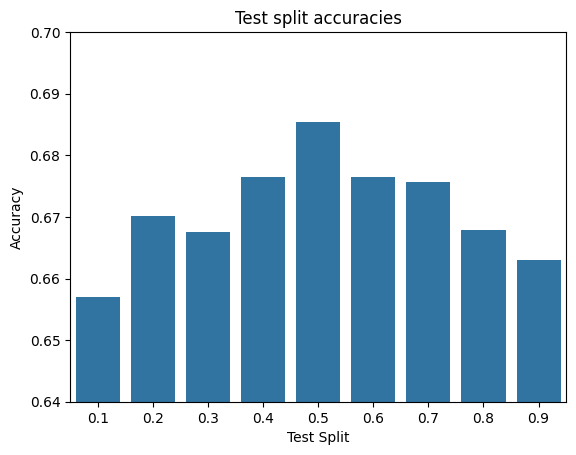

In [35]:
# plotting accuracy for each test size
plt.figure()
plt.ylim(0.64,0.7)
sns.barplot(x=test_list[:, 0], y=test_list[:, 1])
plt.xlabel("Test Split")
plt.ylabel("Accuracy")
plt.title("Test split accuracies")
plt.show()

The pattern of the accuracies is common, with split fractions of 0.1 and 0.9 typically having the lowest accuracy, and 0.4 and 0.5 having the highest accuracy. Too little training data means the model might not have reached proper accuracy, and too much training means that any noise in the test data could be incorrectly classified.

Lets now look at how varying the class threshold affects the neural network's performance.

In [28]:
thresholds = [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75]

epochs = 10
split_list = np.ndarray((len(thresholds), 3))
list_index = 0
for threshold in thresholds:
    y = (model_df["koi_score"] >= threshold).astype(int)
    start = time.time()

    split_list[list_index, 0] = threshold
    
    X_train, X_test, y_train, y_test = split(X, y, 0.5) # Split function is defined in functions.py
    X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = tensors(X_train, X_test, y_train, y_test) # defined in functions.py
    train_loader, test_loader, train_df, test_df, pos_weight = load_data(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, device) # defined in functions.py

    model = MLP(input_dim=X_train.shape[1]).to(device)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model = training(epochs, train_loader, model,loss_func, optimizer, device)
    acc = testing(model, X_test_tensor, y_test_tensor, device)
    
    end = time.time()
    split_list[list_index, 1] = acc
    split_list[list_index, 2] = end - start
    list_index += 1

best_split_index = np.argmax(split_list[:,1])
best_split = split_list[best_split_index,0]
best_acc_split = split_list[best_split_index,1]
print(f"Best split threshold: {best_split}, with accuracy: {best_acc_split}")

Best split threshold: -0.5, with accuracy: 0.6775969962453067


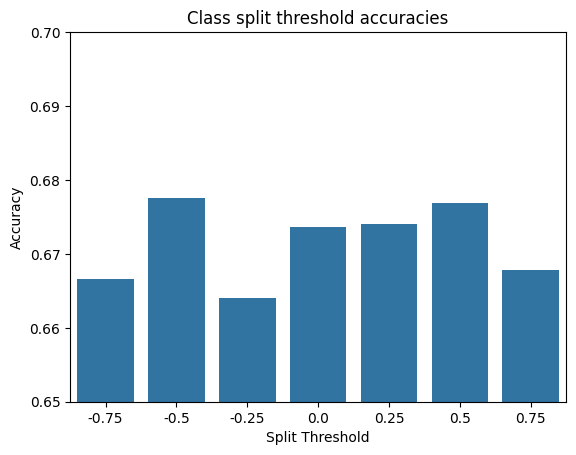

In [29]:
plt.figure()
plt.ylim(0.65,0.7)
sns.barplot(x=split_list[:, 0], y=split_list[:, 1])
plt.xlabel("Split Threshold")
plt.ylabel("Accuracy")
plt.title("Class split threshold accuracies")
plt.show()

After running the loop a few times, we can see that there is not much of a pattern in the accuracies. A threshold of -0.75 tends to be less accurate, as does 0.75. This makes sense, as there is less data for these extreme thresholds, making them more susceptible to any noise in the data.

We've looked at how accuracy varies with split fractions and class thresholds, but what about run time?

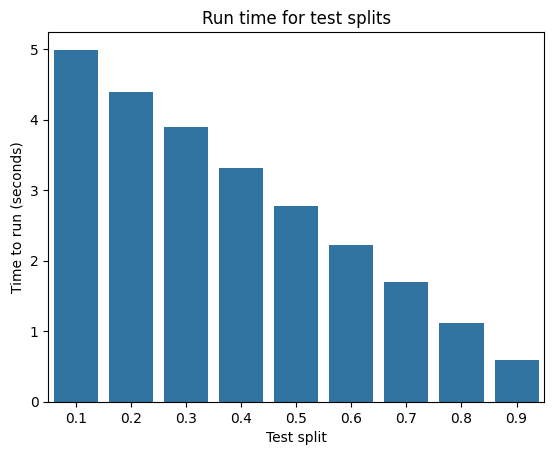

In [36]:
# Comparing run times for various train / test splits
plt.figure()
sns.barplot(x=test_list[:,0], y=test_list[:,2])
plt.xlabel("Test split")
plt.ylabel("Time to run (seconds)")
plt.title("Run time for test splits")
plt.show()

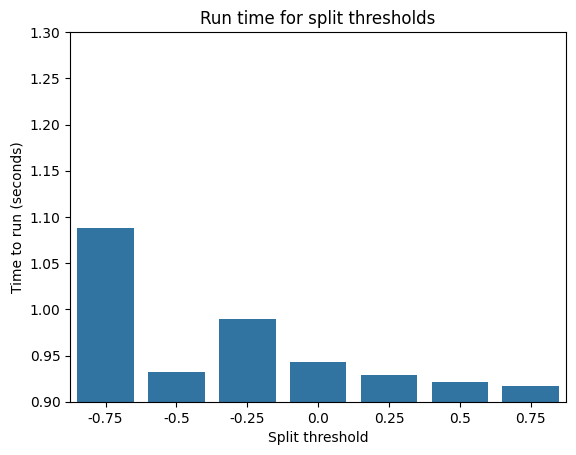

In [31]:
plt.figure()
plt.ylim(0.9,1.3)
sns.barplot(x=split_list[:,0], y=split_list[:,2])
plt.xlabel("Split threshold")
plt.ylabel("Time to run (seconds)")
plt.title("Run time for split thresholds")
plt.show()

The run times for various train / test splits have a distinct pattern, with lower split fractions taking longer to run and larger fractions taking a lot less time. This is due to the fact that a lower fraction means more data kept for training than for testing, and so there is more training to be done, taking a longer time. 

For varying split thresholds, the run time for each threshold is much more variable, and there is no kind of pattern that emerges over many runs. This suggests that the NN is resistant to imbalance in class sizes, which is very useful.